In [1]:
import cv2
import numpy as np
import torch
import math
import pathlib
from IPython.display import display as ipy_display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import time


# Define real tennis ball radius in meters (3.25 cm radius)
TENNIS_BALL_RADIUS_M = 0.0325

In [2]:
import cv2
import numpy as np
import torch
import math
import pathlib
from IPython.display import display as ipy_display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Define real tennis ball radius in meters (3.25 cm radius)
TENNIS_BALL_RADIUS_M = 0.0325

class TennisBallDetectorHeight:
    """Detect tennis balls and calculate distances and angles relative to the camera.

    This class uses a YOLO model for detecting tennis balls and calculates the horizontal 
    distance, total distance, and angle relative to the camera for robot steering purposes. 
    Optionally, frames can be shown, and verbose output can be enabled.
    """

    def __init__(self, model_path, camera_matrix=None, distortion_coeffs=None, collection_zone=None, camera_height=0, cache=True, camera=False, show_frames=False, windows=False, verbose=False):
        """Initializes the TennisBallDetector.

        Args:
            model_path (str): Path to the trained YOLO model.
            camera_matrix (np.ndarray, optional): Camera matrix from calibration. Default is None.
            distortion_coeffs (np.ndarray, optional): Distortion coefficients from calibration. Default is None.
            collection_zone (tuple, optional): A tuple defining the region for collection (x_min, y_min, x_max, y_max). Default is None.
            camera_height (float, optional): Height of the camera from the ground (in meters). Default is 0.
            cache (bool, optional): If True, cache the YOLO model. Default is True.
            camera (bool, optional): If True, capture frames from the camera instead of reading from an image. Default is False.
            show_frames (bool, optional): If True, display frames with bounding boxes during detection. Default is False.
            windows (bool, optional): If True, adapts for Windows OS path handling. Default is False.
            verbose (bool, optional): If True, print additional details during detection (e.g., vertical distance). Default is False.
        """
        if windows:
            pathlib.PosixPath = pathlib.WindowsPath
        self.model_path = pathlib.Path(model_path)
        self.model_path_str = str(self.model_path)

        # Load YOLO model based on caching preference
        if cache:
            self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=self.model_path_str, trust_repo=True)
        else:
            self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=self.model_path_str, force_reload=True)

        self.camera_matrix = camera_matrix
        self.distortion_coeffs = distortion_coeffs
        self.collection_zone = collection_zone
        self.camera_height = camera_height
        self.camera_mode = camera
        self.show_frames = show_frames
        self.verbose = verbose

        if self.camera_mode:
            self.camera = cv2.VideoCapture(0)
            if not self.camera.isOpened():
                print("Error: Could not open USB camera.")
                exit()

    def set_input_source(self, camera=True):
        """Dynamically changes the input source to either the camera or an image file.

        Args:
            camera (bool): If True, use camera input. If False, use image input.
        """
        self.camera_mode = camera
        if self.camera_mode:
            if not hasattr(self, 'camera') or not self.camera.isOpened():
                self.camera = cv2.VideoCapture(0)
                if not self.camera.isOpened():
                    print("Error: Could not open USB camera.")
                    exit()

    def undistort(self, frame):
        """Undistorts the image using the camera matrix and distortion coefficients.

        Args:
            frame (np.ndarray): The distorted input frame.

        Returns:
            np.ndarray: The undistorted frame.
        """
        if self.camera_matrix is not None and self.distortion_coeffs is not None:
            return cv2.undistort(frame, self.camera_matrix, self.distortion_coeffs)
        return frame

    def calculate_distance(self, u, v, r_px):
        """Calculates the total and horizontal distance to the tennis ball, as well as the angle.

        Args:
            u (float): The x-coordinate of the detected object (in pixels).
            v (float): The y-coordinate of the detected object (in pixels).
            r_px (float): The detected radius of the object (in pixels).

        Returns:
            tuple: A tuple containing:
                - horizontal_distance (float): The horizontal distance to the ball in meters.
                - total_distance (float): The total distance to the ball in meters.
                - angle (float): The horizontal angle to the ball in radians.
        """
        if r_px == 0:
            print("Error: Detected radius is zero, cannot calculate distance.")
            return None, None, None

        fx = self.camera_matrix[0, 0]  # Focal length in x direction
        cx = self.camera_matrix[0, 2]  # Principal point x-coordinate

        total_distance = fx * TENNIS_BALL_RADIUS_M / r_px

        if self.camera_height > 0:
            horizontal_distance = math.sqrt(max(total_distance**2 - self.camera_height**2, 0))
        else:
            horizontal_distance = total_distance

        y = (u - cx) * (TENNIS_BALL_RADIUS_M / r_px)
        angle = math.asin(y / horizontal_distance) if horizontal_distance != 0 else 0

        return horizontal_distance, total_distance, angle

    def is_in_collection_zone(self, u, v):
        """Checks if the given coordinates are within the collection zone.

        Args:
            u (float): The x-coordinate in pixels.
            v (float): The y-coordinate in pixels.

        Returns:
            bool: True if within the collection zone, False otherwise.
        """
        if self.collection_zone:
            x_min, y_min, x_max, y_max = self.collection_zone
            return x_min <= u <= x_max and y_min <= v <= y_max
        return False

    def detect(self, retry=True, max_num_retries=20, retry_interval=1, image_path=None):
        """Detects the tennis ball and returns relevant distance and angle information.

        Uses camera capture if camera_mode is enabled, or reads from image_path if camera=False.

        Args:
            retry (bool, optional): If True, retry if capture fails. Default is True.
            max_num_retries (int, optional): Maximum number of retries if capture fails. Default is 20.
            retry_interval (int, optional): Time in seconds to wait between retries. Default is 1.
            image_path (str, optional): Path to an image to use for detection when camera_mode=False. Default is None.

        Returns:
            dict: A dictionary containing:
                - 'horizontal_distance' (float): The horizontal distance to the ball in meters.
                - 'total_distance' (float, optional): The total distance to the ball in meters (only when verbose=True).
                - 'angle' (float, optional): The horizontal angle to the ball in radians (only when verbose=True).
                - 'in_collection_zone' (bool): True if the ball is within the collection zone, False otherwise.
        """
        # Base detection result with values needed for both verbose and non-verbose modes
        detection_result = {
            "horizontal_distance": None,
            "in_collection_zone": False
        }

        if self.verbose:
            detection_result.update({
                "total_distance": None,
                "angle": None
            })

        frame = None
        if self.camera_mode:
            counter = 0
            while True:
                ret, frame = self.camera.read()
                if not ret:
                    print("Error: Failed to capture image.")
                    if not retry or counter >= max_num_retries:
                        return detection_result
                    counter += 1
                    time.sleep(retry_interval)
                    continue
                break
        else:
            if image_path is None:
                print("Error: No image path provided for detection.")
                return detection_result
            frame = cv2.imread(image_path)
            if frame is None:
                print(f"Error: Failed to load image from {image_path}.")
                return detection_result

        undistorted_frame = self.undistort(frame)
        results = self.model(undistorted_frame)

        detections = results.xyxy[0].cpu().numpy()  # Get detections in numpy format
        if len(detections) > 0:
            x1, y1, x2, y2, confidence, class_id = detections[0]

            # Calculate center (u, v) and radius in pixels
            u = (x1 + x2) / 2
            v = (y1 + y2) / 2
            r_px = (x2 - x1) / 2

            horizontal_distance, total_distance, angle = self.calculate_distance(u, v, r_px)

            detection_result["horizontal_distance"] = horizontal_distance
            detection_result["in_collection_zone"] = self.is_in_collection_zone(u, v)

            if self.verbose:
                detection_result["total_distance"] = total_distance
                detection_result["angle"] = angle

                # Verbose output
                print(f"Horizontal Distance: {horizontal_distance:.2f} meters")
                print(f"Total Distance: {total_distance:.2f} meters")
                print(f"Angle: {math.degrees(angle):.2f} degrees")
                print(f"In Collection Zone: {detection_result['in_collection_zone']}")

                if self.camera_height > 0:
                    print(f"Camera Height: {self.camera_height} meters")
                    print(f"Vertical Distance: {self.camera_height} meters (from floor)")

            # Display the frame with bounding box and label
            if self.show_frames:
                for index, obj in results.pandas().xyxy[0].iterrows():
                    x_min, y_min = int(obj['xmin']), int(obj['ymin'])
                    x_max, y_max = int(obj['xmax']), int(obj['ymax'])
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                    label = f"{obj['name']} {obj['confidence']:.2f}"
                    cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                clear_output(wait=True)
                plt.figure(figsize=(10, 6))
                plt.imshow(frame_rgb)
                plt.axis('off')  # Hide axes ticks
                ipy_display(plt.gcf())
                plt.close()

        else:
            print("No detections found.")
            return detection_result

        return detection_result


In [3]:
# Load the YOLO model and calibration data
model_path = 'best.pt'
calibration_data = np.load('camera_calibration_calib6.npz')
camera_matrix = calibration_data['camera_matrix']
distortion_coeffs = calibration_data['dist_coeffs']
collection_zone = (200, 150, 400, 350)  # Define a region for collection
camera_height = 0.02  # Camera height in meters (2 cm)

print("Camera Matrix:\n", camera_matrix)
print("Distortion Coefficients:\n", distortion_coeffs)

# Initialize the TennisBallDetector with camera height
detector = TennisBallDetectorHeight(
    model_path=model_path, 
    camera_matrix=camera_matrix, 
    distortion_coeffs=distortion_coeffs, 
    collection_zone=collection_zone, 
    camera_height=camera_height, 
    camera=False,  # Using an image file input
    show_frames=True,  # Show the frames during detection
    windows=True,  # Path handling for Windows
    verbose=True   # Enable verbose logging for debugging
)


Camera Matrix:
 [[662.92803145   0.         300.07862351]
 [  0.         661.96334614 219.64939065]
 [  0.           0.           1.        ]]
Distortion Coefficients:
 [[-0.20717733 -0.01250375 -0.00141472  0.00173841 -0.48217625]]


Using cache found in C:\Users\aarus/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-9-26 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Quadro P620, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


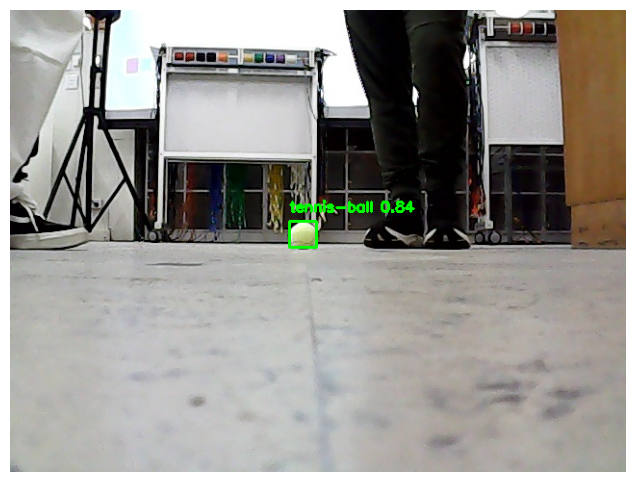

Horizontal Distance: 1.56 meters
Total Distance: 1.56 meters
Angle: 0.40 degrees


In [12]:
# Load the YOLO model and calibration data
model_path = 'best.pt'
calibration_data = np.load('camera_calibration_calib6.npz')
camera_matrix = calibration_data['camera_matrix']
distortion_coeffs = calibration_data['dist_coeffs']
collection_zone = (200, 150, 400, 350)  # Define a region for collection
camera_height = 0.02  # Camera height in meters (2 cm)

# Initialize the TennisBallDetector with camera height
detector = TennisBallDetectorHeight(
    model_path=model_path, 
    camera_matrix=camera_matrix, 
    distortion_coeffs=distortion_coeffs, 
    collection_zone=collection_zone, 
    camera_height=camera_height, 
    camera=False,  # Using an image file input
    show_frames=False,  # Turn off frame display unless verbose=True
    windows=True,  # Path handling for Windows
    verbose=True   # Set to True to enable detailed output and bounding box display
)

# Provide the image path for testing
image_path = '../tennis_ball/image_0.jpg'  # Replace with the correct path to the image

# Detect tennis ball and process results
for _ in range(3):  # Run detection for 3 frames as a test
    detection = detector.detect(image_path=image_path)  # Run detection
    
    # Always available: horizontal_distance and in_collection_zone
    horizontal_distance = detection["horizontal_distance"]
    in_collection_zone = detection["in_collection_zone"]

    # Production logic: Only process valid detections
    if horizontal_distance is not None:
        # Use horizontal distance and check if the ball is in the collection zone
        if detector.verbose:
            # Additional information in verbose mode
            total_distance = detection.get("total_distance")
            angle = detection.get("angle")

            # Draw and display bounding box and image if verbose=True
            detector.show_frames = True
            print(f"Horizontal Distance: {horizontal_distance:.2f} meters")
            print(f"Total Distance: {total_distance:.2f} meters")
            print(f"Angle: {math.degrees(angle):.2f} degrees")

        # Example: if in_collection_zone, robot collects the ball
        if in_collection_zone:
            # Logic for collecting the ball or positioning the robot
            pass
    else:
        # Handle no detection case (e.g., no action or error logging)
        pass


In [13]:
# EXAMPLE USAGE WITH CAMERA 

import cv2
import time

# Load the YOLO model and calibration data
model_path = 'best.pt'
calibration_data = np.load('camera_calibration_calib6.npz')
camera_matrix = calibration_data['camera_matrix']
distortion_coeffs = calibration_data['dist_coeffs']
collection_zone = (200, 150, 400, 350)  # Define a region for collection
camera_height = 0.02  # Camera height in meters (2 cm)

# Initialize the TennisBallDetector for camera feed (camera=True)
detector = TennisBallDetector(
    model_path=model_path, 
    camera_matrix=camera_matrix, 
    distortion_coeffs=distortion_coeffs, 
    collection_zone=collection_zone, 
    camera_height=camera_height, 
    camera=True,  # Set camera to True for real-time camera input
    show_frames=False,  # Turn off frame display for production (set True in verbose mode)
    windows=True,  # Path handling for Windows
    verbose=False  # Set to False for production, set to True for more details
)

# Use a continuous loop for real-time detection
while True:
    detection = detector.detect()  # Detect using the camera feed

    # Always available: horizontal_distance and in_collection_zone
    horizontal_distance = detection["horizontal_distance"]
    in_collection_zone = detection["in_collection_zone"]

    # Production logic: Only process valid detections
    if horizontal_distance is not None:
        # Use horizontal distance and check if the ball is in the collection zone
        if detector.verbose:
            # Additional information in verbose mode
            total_distance = detection.get("total_distance")
            angle = detection.get("angle")
            # Use total_distance and angle for further logic
            print(f"Total Distance: {total_distance:.2f} meters")
            print(f"Angle: {math.degrees(angle):.2f} degrees")

        # Example: if in_collection_zone, robot collects the ball
        if in_collection_zone:
            # Logic for collecting the ball or positioning the robot
            print("Ball is in the collection zone")
    else:
        # Handle no detection case (e.g., no action or error logging)
        print("No ball detected.")

    # Optionally, add a small delay to prevent excessive CPU usage
    time.sleep(0.1)

    # Exit loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup: Release the camera and close OpenCV windows
detector.camera.release()
cv2.destroyAllWindows()


Using cache found in C:\Users\aarus/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-9-26 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Quadro P620, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No ball detected.
No detections found.
No b

KeyboardInterrupt: 